# Tugas Praktikum Minggu 9: Audio Classification
### Nicholas Juan Kalvin P. | 162012133068
<hr>



### Informasi Dataset
<p>Audio classification adalah teknik dimana berbagai macam bentukan suara dibedakan berdasarkan karakter-karakter uniknya. Pada praktikum audio classification ini, digunakan dataset terbuka <i>Free Spoken Digit Dataset (FSDD)</i> yang adalah dataset audio/pembicaraan yang simpel yang terdiri dari rekaman penyebutan angka pada 8kHz dengan ekstensi file `wav`. Jumlah rekaman terdiri dari 3000 rekaman yang diucapkan oleh 6 orang berbeda, dengan angka yang diucapkan adalah angka 0 sampai 9.</p>

### Tujuan Akhir Praktikum
<p>Selain sebagai pemenuhan nilai mata kuliah <i>Data Mining</i>, dimana fungsi dari model yang akan diciptakan dapat mengklasifikasikan angka yang diucapkan seperti yang terdapat di dataset.

<hr>

In [2]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf
import random

# Loading Data

Karena banyaknya file yang harus di proses, data yang di masukkan ke dalam `runtime` bukanlah semuanya sekaligus karena akan menghabiskan banyak sumber daya. Metode memasukkan file yang dipilih adalah dengan mencatatat semua nama file, label, dan path dari file ke dalam dataframe. Saat program membaca konten dataframe, pada saat itulah file audio dibaca.

In [3]:
data_path = "./nicolas/recordings"
fixedname = ['george', 'jackson', 'lucas','nicolas', 'theo', 'yweweler']
sets = []
name = []
numbers = []

for s in range(0, 10):
    for n in fixedname:
        for i in range(0, 50):
            sets.append(s)
            name.append(n)
            numbers.append(i)

list_files = pd.DataFrame(data={'number': sets, 'name': name, 'set': numbers})
list_files['path'] = data_path + '/' + list_files['number'].astype(str) +'_' + list_files['name'] + '_' + list_files['set'].astype(str) + '.wav'

In [4]:
list_files.head(20)


,number,name,set,path
0,0,george,0,./nicolas/recordings/0_george_0.wav
1,0,george,1,./nicolas/recordings/0_george_1.wav
2,0,george,2,./nicolas/recordings/0_george_2.wav
3,0,george,3,./nicolas/recordings/0_george_3.wav
4,0,george,4,./nicolas/recordings/0_george_4.wav
5,0,george,5,./nicolas/recordings/0_george_5.wav
6,0,george,6,./nicolas/recordings/0_george_6.wav
7,0,george,7,./nicolas/recordings/0_george_7.wav
8,0,george,8,./nicolas/recordings/0_george_8.wav
9,0,george,9,./nicolas/recordings/0_george_9.wav


In [5]:
print('Bentuk dataframe:', list_files.shape)
print('Kolom pada dataframe:', list_files.columns)

list_files.groupby('name').sum(numeric_only=True)

Bentuk dataframe: (3000, 4)
Kolom pada dataframe: Index(['number', 'name', 'set', 'path'], dtype='object')


,number,set
name,,
george,2250,12250
jackson,2250,12250
lucas,2250,12250
nicolas,2250,12250
theo,2250,12250
yweweler,2250,12250


Dari tampilan bentukan data diatas terlihat bahwa jumlah pembagian data diantara nama-nama dan jumlah set adalah seimbang. Tidak diperlukan balancing. Data juga diasumsikan tidak mengandung null value atau duplikasi

<hr>

# EDA and Visualization

## Random sampling

In [6]:
def visulize_random_sample(dataframe):
  #to hear the audio sample
  filerandom = list_files.sample(ignore_index=True, axis=0)
  filename = list(filerandom['path'])[0]
  sample_sound, sample_rate = librosa.load(filename)
  print(filerandom)
  return sample_sound, sample_rate


In [27]:
sample_sound, sample_rate = visulize_random_sample(list_files)
ipd.Audio(sample_sound, rate=sample_rate)


   number     name  set                                   path
0       5  nicolas   28  ./nicolas/recordings/5_nicolas_28.wav


### Waveform

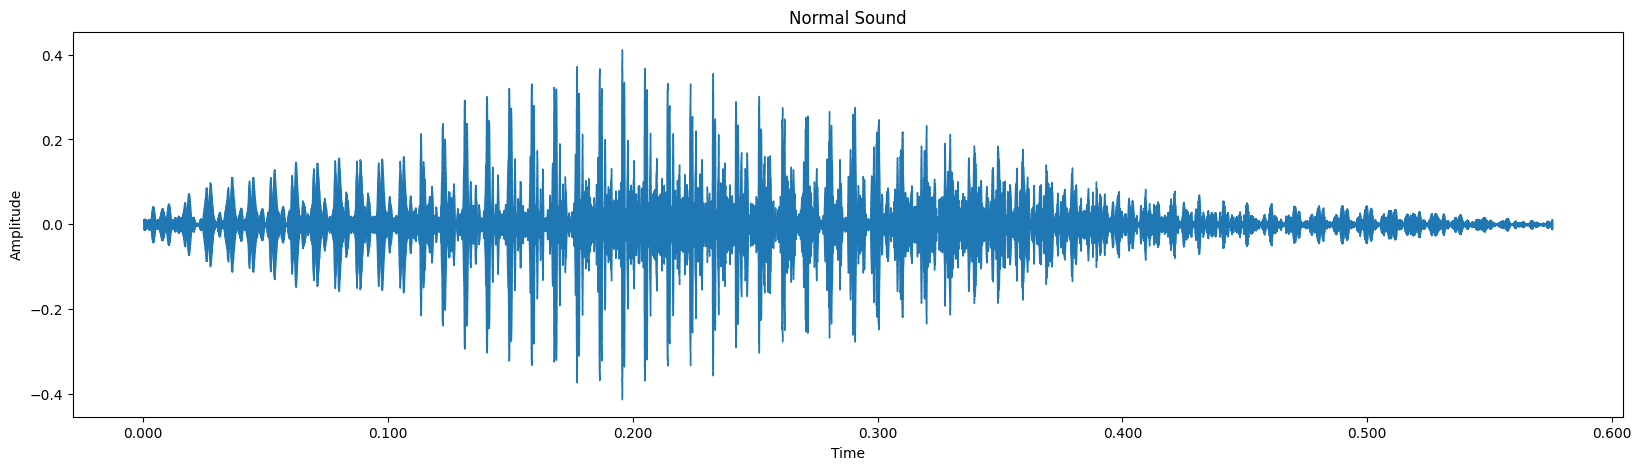

In [8]:
#librosa.display.waveshow(data, sr=sampling_rate)

plt.figure(figsize=(20,5))
librosa.display.waveshow(sample_sound, sr = sample_rate)
plt.title("Normal Sound")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

### Spectrum

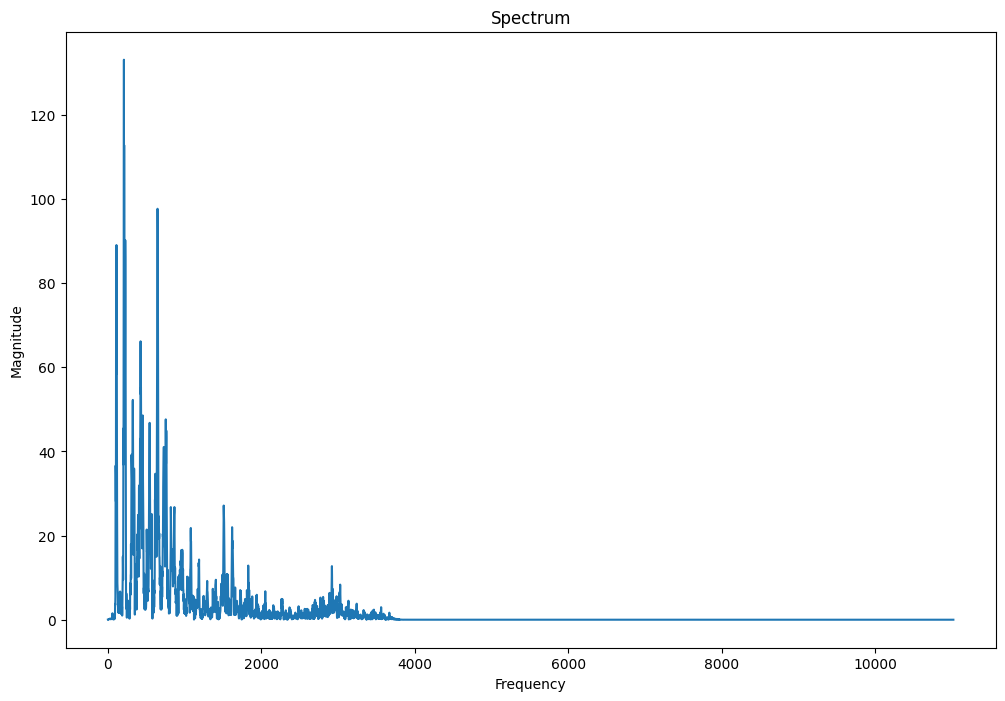

In [9]:
fft_normal = np.fft.fft(sample_sound) #fast Fourier transform
magnitude_normal = np.abs(fft_normal)
freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) 
half_freq = freq_normal[:int(len(freq_normal)/2)]
half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]

plt.figure(figsize=(12,8))
plt.plot(half_freq,half_magnitude)
plt.title("Spectrum")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

### Spectogram

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


Text(0.5, 1.0, 'Spectrogram')

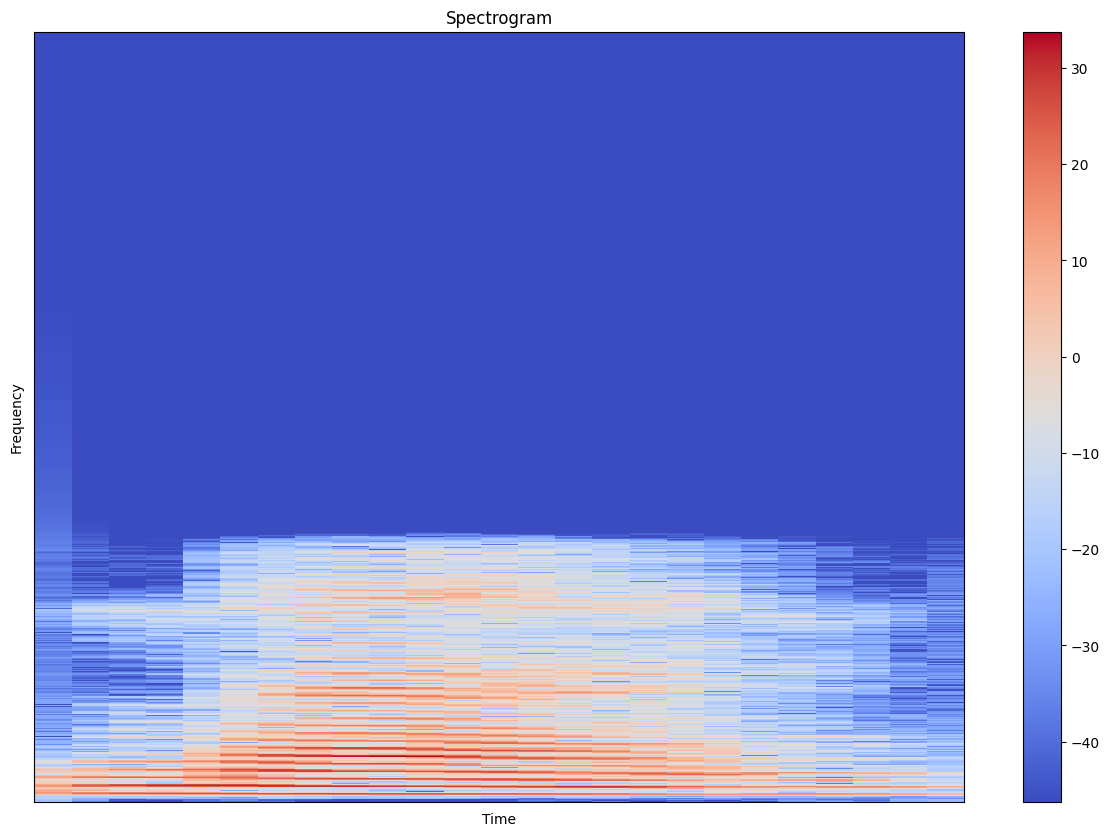

In [10]:
# STFT -> spectrogram
hop_length = 512 # in num. of samples
n_fft = 2048 # window in num. of samples

# calculate duration hop length and window in seconds
hop_length_duration = float(hop_length)/sample_rate
n_fft_duration = float(n_fft)/sample_rate

print("STFT hop length duration is: {}s".format(hop_length_duration))
print("STFT window duration is: {}s".format(n_fft_duration))

# perform stft
stft_normal = librosa.stft(sample_sound, n_fft=n_fft, hop_length=hop_length)

# calculate abs values on complex numbers to get magnitude
spectrogram = np.abs(stft_normal)
log_spectrogram = librosa.amplitude_to_db(spectrogram)

# display spectrogram
plt.figure(figsize=(15,10))
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
#plt.set_cmap("YlOrBr")
plt.title("Spectrogram")

### MFCCs

C:\Users\nicho\AppData\Local\Temp\ipykernel_7728\697840238.py:3: FutureWarning: Pass y=[-0.00958685 -0.01132322 -0.01157712 ...  0.00928538  0.00565467
  0.        ], sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  MFCCs = librosa.feature.mfcc(sample_sound, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)


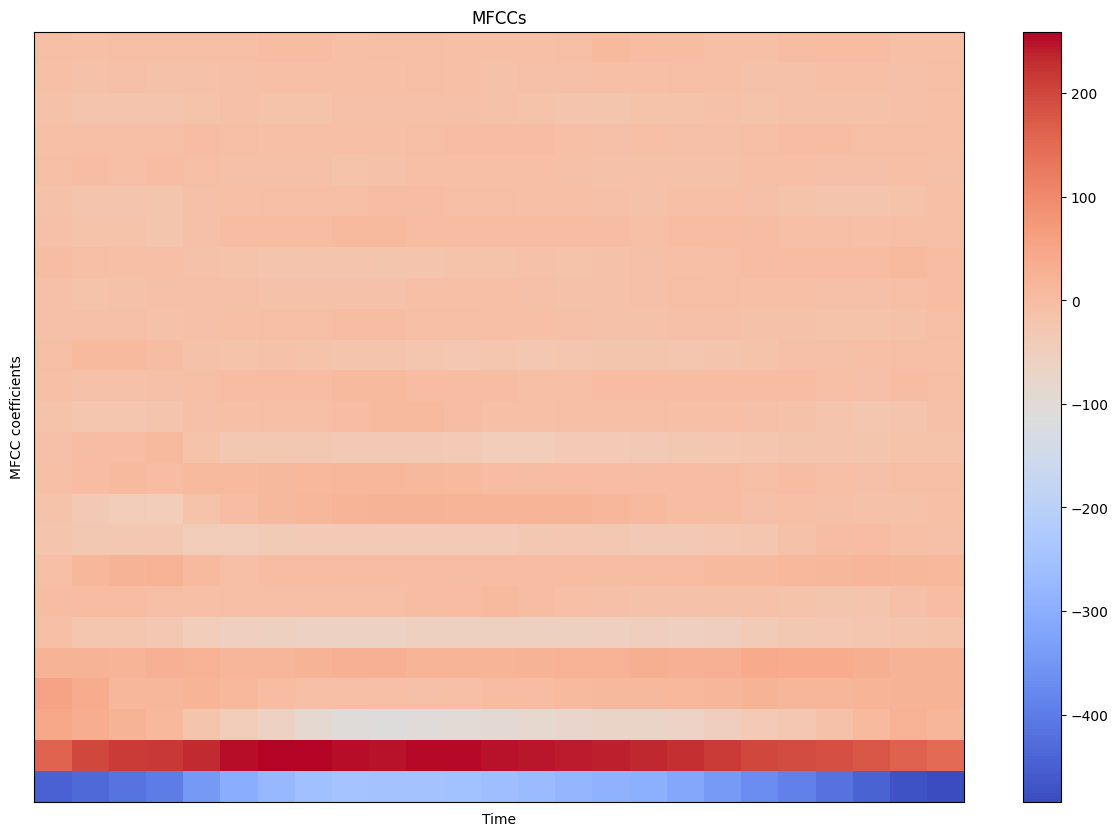

In [11]:
# MFCCs
# extract 25 MFCCs
MFCCs = librosa.feature.mfcc(sample_sound, sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=25)

# display MFCCs
plt.figure(figsize=(15,10))
librosa.display.specshow(MFCCs, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC coefficients")
plt.colorbar()
#plt.set_cmap("YlOrBr")
plt.title("MFCCs")

# show plots
plt.show()

Visualisasi diatas adalah visualisasi yang membantu dalam menentukan langkah preprosesing selanjutnya, atau untuk menentukan apakah data audio butuh di bersihkan secara mendalam.

<hr>

## *Encoding*

Encoding adalah proses transformasi data menjadi bentuk lain yang memberikan keuntungan dan efisiensi pada saat file dijalankan, ditransmisi atau di proses. Pada praktikum ini, encoding dilakukan untuk mengunbah bentuk file audio yang asli yang berupa matriks satu dimensi dengan tipe objek `float32` menjadi bentuk lain. Encoding juga dapat berupa data hasil ekstraksi fitur.

In [29]:
def load_file_data (paths, duration=10, sr=22050):
    input_length=sr*duration
    data = []
    for sound_file in paths:
        try:
            print ("load file ",sound_file)
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("    fixing audio lenght :", sound_file)
                y = librosa.util.fix_length(X, input_length)                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=25).T,axis=0)             
        except Exception as e:
            print("Error encountered while parsing file: ", e)        
            return
        feature = np.array(mfccs).reshape([-1,1])
        data.append(feature)
    return data

Fungsi diatas adalah `routine` yang mempermudah preprosesing the menggabungkan fungsi pembacaan file dan transformasi file menjadi MFCC secara sekaligus. 

In [34]:
sounds = load_file_data (list_files['path'], duration=3)
labels = list_files['number']


load file  ./nicolas/recordings/0_george_0.wav
fixing audio lenght : ./nicolas/recordings/0_george_0.wav
load file  ./nicolas/recordings/0_george_1.wav
fixing audio lenght : ./nicolas/recordings/0_george_1.wav
load file  ./nicolas/recordings/0_george_2.wav
fixing audio lenght : ./nicolas/recordings/0_george_2.wav
load file  ./nicolas/recordings/0_george_3.wav
fixing audio lenght : ./nicolas/recordings/0_george_3.wav
load file  ./nicolas/recordings/0_george_4.wav


C:\Users\nicho\AppData\Local\Temp\ipykernel_7728\1308934457.py:12: FutureWarning: Pass size=66150 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  y = librosa.util.fix_length(X, input_length)


fixing audio lenght : ./nicolas/recordings/0_george_4.wav
load file  ./nicolas/recordings/0_george_5.wav
fixing audio lenght : ./nicolas/recordings/0_george_5.wav
load file  ./nicolas/recordings/0_george_6.wav
fixing audio lenght : ./nicolas/recordings/0_george_6.wav
load file  ./nicolas/recordings/0_george_7.wav
fixing audio lenght : ./nicolas/recordings/0_george_7.wav
load file  ./nicolas/recordings/0_george_8.wav
fixing audio lenght : ./nicolas/recordings/0_george_8.wav
load file  ./nicolas/recordings/0_george_9.wav
fixing audio lenght : ./nicolas/recordings/0_george_9.wav
load file  ./nicolas/recordings/0_george_10.wav
fixing audio lenght : ./nicolas/recordings/0_george_10.wav
load file  ./nicolas/recordings/0_george_11.wav
fixing audio lenght : ./nicolas/recordings/0_george_11.wav
load file  ./nicolas/recordings/0_george_12.wav
fixing audio lenght : ./nicolas/recordings/0_george_12.wav
load file  ./nicolas/recordings/0_george_13.wav
fixing audio lenght : ./nicolas/recordings/0_geo

In [15]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# Map label text to integer
CLASSES = ['1','2','3','4','5','6','7','8','9']
NB_CLASSES=len(CLASSES)


In [16]:
from sklearn.model_selection import train_test_split

X = np.asarray(sounds).astype(np.float32)
y = np.asarray(list_files['number'])
# split data into Train, Validation and Test

x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, train_size=0.8, random_state=42, shuffle=True)

y_train = np.array(tf.keras.utils.to_categorical(y_train, num_classes=10))
y_test = np.array(tf.keras.utils.to_categorical(y_test, num_classes=10))
y_val = np.array(tf.keras.utils.to_categorical(y_val, num_classes=10))
y_test=np.array(tf.keras.utils.to_categorical(y_test, num_classes=10))

In [17]:
print('Length of x_train:', len(x_train))
print('Length of y_train:', len(y_train))
print('Length of x_test:', len(x_test))
print('Length of y_test:', len(y_test))
print('Length of x_val:', len(x_val))
print('Length of y_val:', len(y_val))
print()
print('Shape of x_train:', (x_train.shape))
print('Shape of y_train:', (y_train.shape))
print()
print('Shape of x_test:', (x_test.shape))
print('Shape of y_test:', (y_test.shape))
print()
print('Shape of x_val:', (x_val.shape))
print('Shape of y_val:', (y_val.shape))


Length of x_train: 1920
Length of y_train: 1920
Length of x_test: 600
Length of y_test: 600
Length of x_val: 480
Length of y_val: 480

Shape of x_train: (1920, 25, 1)
Shape of y_train: (1920, 10)

Shape of x_test: (600, 25, 1)
Shape of y_test: (600, 10, 10)

Shape of x_val: (480, 25, 1)
Shape of y_val: (480, 10)


# LSTM Model

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, ModelCheckpoint,TensorBoard,ProgbarLogger
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [19]:
model = Sequential()

model.add(Bidirectional(LSTM(128, dropout=0.05, recurrent_dropout=0.20, return_sequences=True), input_shape = (25,1)))

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Flatten())

model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer=Adam(1e-4), metrics=['acc'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 25, 256)          133120    
 l)                                                              
                                                                 
 dense (Dense)               (None, 25, 128)           32896     
                                                                 
 dropout (Dropout)           (None, 25, 128)           0         
                                                                 
 dense_1 (Dense)             (None, 25, 128)           16512     
                                                                 
 dense_2 (Dense)             (None, 25, 64)            8256      
                                                                 
 dense_3 (Dense)             (None, 25, 64)            4160      
                                                        

In [20]:
history=model.fit(x_train, y_train, 
                  batch_size=3, 
                  epochs=30,
                  validation_data=(x_val, y_val)) 

Epoch 1/30
640/640 [==============================] - 125s 186ms/step - loss: 2.0977 - acc: 0.2667 - val_loss: 1.5319 - val_acc: 0.4625
Epoch 2/30
640/640 [==============================] - 117s 184ms/step - loss: 1.1495 - acc: 0.5901 - val_loss: 0.8420 - val_acc: 0.6771
Epoch 3/30
640/640 [==============================] - 117s 183ms/step - loss: 0.8624 - acc: 0.6776 - val_loss: 0.6915 - val_acc: 0.7563
Epoch 4/30
505/640 [======================>.......] - ETA: 23s - loss: 0.7391 - acc: 0.7215

KeyboardInterrupt: 

<AxesSubplot: >

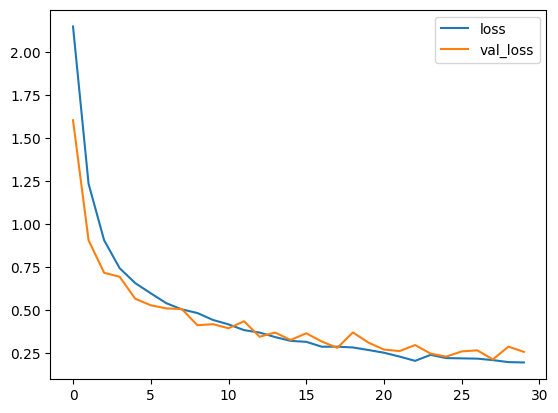

In [ ]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()

<AxesSubplot: >

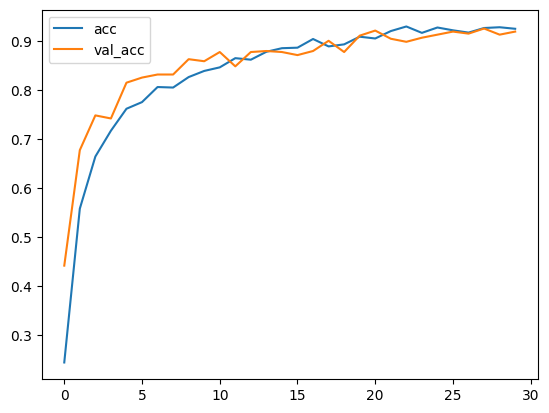

In [ ]:
losses[['acc','val_acc']].plot()

# Prediction

In [ ]:
# make a prediction
y_pred = model.predict(x_test, batch_size=5)
#check scores
scores = model.evaluate(x_test, y_test)
print ("Model evaluation accuracy: ", round(scores[1]*100),"%")

120/120 [==============================] - 7s 51ms/step


InvalidArgumentError: Graph execution error:

Detected at node 'cond/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nicho\AppData\Local\Temp\ipykernel_14344\2729597329.py", line 4, in <module>
      scores = model.evaluate(x_test, y_test)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\metrics\base_metric.py", line 693, in update_state
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions
      y_true, y_pred = tf.cond(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 155, in remove_squeezable_dimensions
      labels = tf.cond(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'cond/remove_squeezable_dimensions/cond/Squeeze'
Detected at node 'cond/remove_squeezable_dimensions/cond/Squeeze' defined at (most recent call last):
    File "C:\Program Files\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Program Files\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\traitlets\config\application.py", line 982, in launch_instance
      app.start()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\tornado\platform\asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 600, in run_forever
      self._run_once()
    File "C:\Program Files\Python310\lib\asyncio\base_events.py", line 1896, in _run_once
      handle._run()
    File "C:\Program Files\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 2885, in run_cell
      result = self._run_cell(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 2940, in _run_cell
      return runner(coro)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3139, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3318, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\IPython\core\interactiveshell.py", line 3378, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\nicho\AppData\Local\Temp\ipykernel_14344\2729597329.py", line 4, in <module>
      scores = model.evaluate(x_test, y_test)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1947, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1727, in test_function
      return step_function(self, iterator)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1713, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1701, in run_step
      outputs = model.test_step(data)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1668, in test_step
      return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\training.py", line 1092, in compute_metrics
      self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\engine\compile_utils.py", line 605, in update_state
      metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\metrics_utils.py", line 77, in decorated
      update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\metrics\base_metric.py", line 143, in update_state_fn
      return ag_update_state(*args, **kwargs)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\metrics\base_metric.py", line 693, in update_state
      y_pred, y_true = losses_utils.squeeze_or_expand_dimensions(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 209, in squeeze_or_expand_dimensions
      y_true, y_pred = tf.cond(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 204, in <lambda>
      squeeze_dims = lambda: remove_squeezable_dimensions(y_true, y_pred)
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 155, in remove_squeezable_dimensions
      labels = tf.cond(
    File "c:\Users\nicho\PycharmProjects\DataMining2\.dm2\lib\site-packages\keras\utils\losses_utils.py", line 157, in <lambda>
      lambda: tf.squeeze(labels, [-1]),
Node: 'cond/remove_squeezable_dimensions/cond/Squeeze'
2 root error(s) found.
  (0) INVALID_ARGUMENT:  Can not squeeze dim[2], expected a dimension of 1, got 10
	 [[{{node cond/remove_squeezable_dimensions/cond/Squeeze}}]]
	 [[cond/then/_107/cond/cond/then/_240/cond/cond/remove_squeezable_dimensions/Equal/_124]]
  (1) INVALID_ARGUMENT:  Can not squeeze dim[2], expected a dimension of 1, got 10
	 [[{{node cond/remove_squeezable_dimensions/cond/Squeeze}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_test_function_125254]

# Saving and loading model

In [ ]:
model.save('number_guesser.hdf5') #HDF5 file (Hierarchical Data Format 5)

In [ ]:
# prediction class 
y_pred = np.asarray(model.predict(x_test, batch_size=32))
y_pred = np.argmax(y_pred,axis=1)
print ("prediction test return :",y_pred[1], "-", int_to_label[y_pred[1]])

NameError: name 'model' is not defined

In [ ]:
def preprocessing (file_path, duration=10, sr=22050):
  input_length=sr*duration
  process_file=[]
  X, sr = librosa.load(file_path, sr=sr, duration=duration) 
  dur = librosa.get_duration(y=X, sr=sr)
  # pad audio file same duration
  if (round(dur) < duration):
    y = librosa.util.fix_length(X, input_length)                
  mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=40, n_fft=512,hop_length=2048).T,axis=0)
  feature = np.array(mfccs).reshape([-1,1])
  process_file.append(feature)
  process_file_array = np.asarray(process_file)
  return process_file_array

In [ ]:
y_pred = np.asarray(model.predict(x_test, batch_size=32))
y_pred = np.argmax(y_pred,axis=1)

19/19 [==============================] - 2s 60ms/step


In [ ]:
target_names = ["artifact", "murmur","normal"]
print(classification_report(y_test.argmax(axis=1), y_pred, target_names = target_names))